In [1]:
import random
import matplotlib.pyplot as plt

In [2]:
def process(arr, brr):
    n = len(arr)
    for _ in range(10000):
        i = random.randint(0,n-2)
        a1 = min(arr[i], (arr[i] + arr[i+1] - brr[i])/2)
        a2 = max(arr[i+1], (arr[i] + arr[i+1] + brr[i])/2)
        arr[i] = a1
        arr[i+1] = a2
    return arr

In [3]:
eps = 10**-3

In [4]:
crr = [2,3,4]
arr = [2,3,4]
brr = [2,1]

In [5]:
zrr = [0,50,100]

In [6]:
zrr = process(zrr, brr)
zrr, (zrr[1] - zrr[0]), (zrr[2] - zrr[1]), sum(zrr)

([0, 50, 100], 50, 50, 150)

In [7]:
zrr = [0,1,4]

In [8]:
zrr = process(zrr, brr)
zrr, (zrr[1] - zrr[0]), (zrr[2] - zrr[1]), sum(zrr)

([-0.5, 1.5, 4], 2.0, 2.5, 5.0)

In [9]:
res2 = []
for i in range(2+1):
    for j in range(3+1):
        for k in range(4+1):
            xrr = [i,j,k]
            xrr = process(xrr, brr)
            print([i,j,k], xrr)
#             if i+j+k >= 5 and xrr[0] <= 0:
#                 assert False
            res2.append(xrr)

[0, 0, 0] [-1.6666666666666665, 0.3333333333333335, 1.3333333333333335]
[0, 0, 1] [-1.3333333333333335, 0.6666666666666665, 1.6666666666666665]
[0, 0, 2] [-1.0, 1.0, 2]
[0, 0, 3] [-1.0, 1.0, 3]
[0, 0, 4] [-1.0, 1.0, 4]
[0, 1, 0] [-1.3333333333333335, 0.6666666666666665, 1.6666666666666665]
[0, 1, 1] [-1.0, 1.0, 2.0]
[0, 1, 2] [-0.666666666666667, 1.333333333333333, 2.333333333333333]
[0, 1, 3] [-0.5, 1.5, 3]
[0, 1, 4] [-0.5, 1.5, 4]
[0, 2, 0] [-1.0, 1.0, 2.0]
[0, 2, 1] [-0.666666666666667, 1.333333333333333, 2.333333333333333]
[0, 2, 2] [-0.3333333333333335, 1.6666666666666665, 2.6666666666666665]
[0, 2, 3] [0, 2, 3]
[0, 2, 4] [0, 2, 4]
[0, 3, 0] [-0.666666666666667, 1.333333333333333, 2.333333333333333]
[0, 3, 1] [-0.3333333333333335, 1.6666666666666665, 2.6666666666666665]
[0, 3, 2] [0, 2.0, 3.0]
[0, 3, 3] [0, 2.5, 3.5]
[0, 3, 4] [0, 3, 4]
[1, 0, 0] [-1.333333333333333, 0.666666666666667, 1.666666666666667]
[1, 0, 1] [-1.0, 1.0, 2.0]
[1, 0, 2] [-0.666666666666667, 1.333333333333333, 

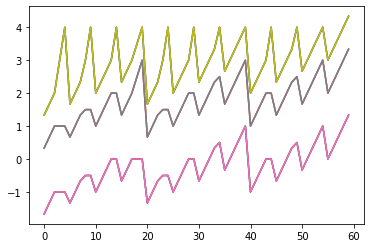

In [10]:
for row in zip(*res2):
    plt.plot(res2)
# plt.plot(*zip(res2)
# plt.plot(*zip(res))

In [11]:
# plt.plot(res)

In [12]:
sum(r[0] >= 0 - eps for r in res2)

28

In [13]:
sum(r[0] >= 1 - eps for r in res2)

4

In [14]:
sum(r[0] >= -1 - eps for r in res2)

56

In [15]:
print(len(res2))

60
